## Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
import pandas as pd

## Data preprocessing

In [147]:
kospi=pd.read_csv('kospi_close_log_return.csv')
kospi

,Unnamed: 0,012510,120030,001430,005385,001530,001795,008730,047040,020120,...,012690,019175,004545,092220,026960,015360,009150,001020,109070,009180
0,0,-0.022472,-0.014370,0.017911,-0.021233,-0.010285,-0.009621,0.004265,-0.014205,-0.016529,...,0.019324,-0.011421,0.019873,0.072786,0.000000,-0.002728,-0.002873,-0.093985,0.000000,-0.011369
1,1,0.031322,-0.002635,-0.040247,0.017022,-0.004946,0.000000,0.000000,-0.037906,-0.003339,...,0.004773,0.000000,0.010780,-0.014431,-0.012084,-0.010989,-0.018883,0.001738,0.003533,0.000000
2,2,0.008772,0.036273,-0.004115,0.012578,0.007058,-0.022815,-0.004265,0.007402,0.000000,...,0.018868,0.000000,0.000000,0.008683,-0.009161,0.005509,0.001466,-0.009552,-0.041574,0.007729
3,3,0.004357,0.003810,0.004115,0.048791,0.001874,0.000000,-0.012903,-0.001476,0.000000,...,0.095735,0.022383,0.021057,-0.073222,0.024243,-0.006892,-0.019217,-0.006279,-0.033753,0.080915
4,4,0.000000,0.005056,-0.004115,0.000000,-0.000702,0.027102,0.008621,-0.011887,0.003339,...,0.021009,-0.001654,0.035854,0.016911,-0.009022,-0.008333,0.019217,-0.001597,0.017036,0.031270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453,2453,-0.018788,-0.006080,-0.005764,-0.003552,0.029288,-0.041607,0.007687,-0.001197,0.136904,...,-0.013196,-0.017263,-0.091197,-0.030003,-0.001071,0.011348,-0.001330,0.027431,0.000000,-0.034820
2454,2454,-0.003454,0.000000,-0.007737,-0.003565,0.003386,-0.001635,-0.020109,-0.009626,-0.127298,...,-0.007619,0.029414,-0.032789,0.003168,-0.001610,0.002817,0.007297,0.015178,0.000000,0.000000
2455,2455,0.000000,0.012122,0.001940,0.001784,-0.011901,0.021053,0.030771,0.008429,0.013296,...,0.000000,-0.031904,-0.070422,-0.019157,0.001610,-0.002817,-0.003310,0.028557,0.000000,-0.005923
2456,2456,0.008614,-0.002010,-0.064022,-0.004466,0.013865,-0.061126,-0.012195,-0.006013,0.000000,...,-0.001914,0.004974,-0.028294,-0.009068,-0.032129,-0.065574,-0.003322,0.013423,0.000000,-0.032196


In [220]:
# X_train_df=kospi.iloc[:400,1:]
# X_test_df=kospi.iloc[400:500,1:]
# print(f"{X_train_df.shape}, {X_test_df.shape}")
# y_train_df=kospi['005930'][1:401]
# y_test_df=kospi['005930'][401:501]
# print(f"{y_train_df.shape}, {y_test_df.shape}")
X_train_df = kospi.iloc[0:1600:4, 1:]
y_train_df = kospi['005930'].iloc[4:1604:4]
# every row from 1601 through 1700
X_test_df  = kospi.iloc[1600:2000:4, 1:]
y_test_df  = kospi['005930'].iloc[1604:2004:4]

print(X_train_df.shape, X_test_df.shape)
print(y_train_df.shape, y_test_df.shape)


(400, 771) (100, 771)
(400,) (100,)


In [222]:
X_train=X_train_df.to_numpy()
X_test=X_test_df.to_numpy()
y_train=y_train_df.to_numpy()
y_test=y_test_df.to_numpy()

In [223]:
mu = X_train.mean(axis=0)           # shape (n_features,)
X_train_cent = X_train - mu         # (n_train, n_features)
X_test_cent  = X_test  - mu         # (n_test,  n_features)

# 2) Estimate the covariance matrix of the centered training data
#    using the unbiased estimator (divisor = n-1):
cov = (X_train_cent.T @ X_train_cent) / (X_train_cent.shape[0] - 1)  # (n_features, n_features)

# 3) Eigen‐decompose cov = E Λ Eᵀ
eigvals, eigvecs = np.linalg.eigh(cov)
#    Add a tiny ε to avoid division‐by‐zero on tiny eigenvalues
eps = 1e-12
inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + eps))  # Λ^(–1/2)

# 4) Build the whitening matrix W = E Λ^(–1/2) Eᵀ
W = eigvecs @ inv_sqrt @ eigvecs.T

# 5) Apply to train & test
X_train_white = X_train_cent @ W
X_test_white  = X_test_cent  @ W

In [224]:
y_train=y_train.reshape(400,1)
y_test=y_test.reshape(100,1)

In [225]:
y_train.shape

(400, 1)

In [226]:
from scipy.linalg import lstsq

def forward_selection(X, y, k):
    n_samples, n_features = X.shape
    # ensure y is a column vector

    selected = []
    remaining = list(range(n_features))

    for _ in range(k):
        best_rss = np.inf
        best_feat = None

        for feat in remaining:
            cand = selected + [feat]
            X_sub = X[:, cand]
            coef, *_ = lstsq(X_sub, y)       # solve OLS
            residuals = y - X_sub.dot(coef)
            rss = np.sum(residuals**2)

            if rss < best_rss:
                best_rss = rss
                best_feat = feat

        selected.append(best_feat)
        remaining.remove(best_feat)

    return selected

def fit_ols(X, y):
    y = y.reshape(-1, 1)
    coef, *_ = lstsq(X, y)
    return coef.ravel()

# ----------------------------
# Example usage
# ----------------------------
# X_train: (2000, 771), y_train: (2000, 1)
# select 10 features
selected_idx = forward_selection(X_train_white, y_train, k=10)
print("Selected feature indices:", selected_idx)

# build reduced matrix and refit final model
X_reduced = X_train_white[:, selected_idx]
coef = fit_ols(X_reduced, y_train)

# compute R²
y_pred = X_reduced.dot(coef.reshape(-1,1))
ss_res = np.sum((y_train - y_pred)**2)
ss_tot = np.sum((y_train - np.mean(y_train))**2)
r2 = 1 - ss_res/ss_tot

print("Coefficients of selected features:", coef)
print(f"Training R² = {r2:.4f}")

Selected feature indices: [70, 5, 270, 725, 310, 324, 376, 146, 603, 430]
Coefficients of selected features: [-0.00416646  0.00483916  0.00451947 -0.00337712 -0.00270389 -0.00413469
  0.00354075  0.0026333   0.00243876 -0.00251187]
Training R² = 0.1969


In [227]:
X_train_reduced = X_train_white[:, selected_idx]
X_test_reduced = X_test_white[:, selected_idx]

## Example data

In [ ]:
# np.random.seed(42)
# N = 200
# D = 1
# X = np.random.uniform(-5, 5, size=(N, D))

# w = np.random.randn(D, 1)
# f_true = lambda X: np.sin(X.dot(w))     # shape (N,1)

# # Noisy observations
# noise_std = 0.1
# y = f_true(X) + noise_std * np.random.randn(N, 1)

# Radial Basis Function Kernel
# Parameters are lengthscale and variance
# Larger the length scale, smoother the function
# Larger variance means larger vertical scale of the output
def rbf_kernel(X1, X2, lengthscale, variance):
    X1s = X1 / lengthscale # (N1, D)
    X2s = X2 / lengthscale # (N2, D)
    sq_dists = (
        np.sum(X1s**2, axis=1)[:,None] #(N1,1)
      + np.sum(X2s**2, axis=1)[None,:] #(1,N2) # with broadcasting it makes (N1,N2)
      - 2*X1s.dot(X2s.T) # (N1,N2)
    )
    return variance * np.exp(-0.5 * sq_dists)

In [ ]:
# Compute the variational bound (eq. 9 in paper)
# sigma2 is the noise added to the final output y
# We DO NOT optimize pseudo-inputs X_m.
def variational_bound(params, X, y, m_idx):
    lengthscale, variance, sigma2 = params
    n = X.shape[0]
    # Inducing inputs
    if m_idx:
        Xm = X[m_idx]
        #Add the Identity matrix * 1e-8 to prevent the Kmm to be singular matrix
        Kmm = rbf_kernel(Xm, Xm, lengthscale, variance) + 1e-8 * np.eye(len(Xm))
        Kmn = rbf_kernel(Xm, X, lengthscale, variance)
        Z = np.linalg.solve(Kmm, Kmn) #Kmm^(-1)*Kmn
        Qnn = Kmn.T.dot(Z)
        # Trace term: Tr(Knn) - Tr(Qnn)
        trace_Knn = variance * n
        trace_Q = np.trace(Qnn)
        trace_term = trace_Knn - trace_Q
        # Build covariance C = Qnn + sigma2 I for likelihood
        C = Qnn + sigma2 * np.eye(n)
    else: #No inducing points
        trace_term = variance * n
        C = sigma2 * np.eye(n)
    # Log marginal likelihood part
    L = np.linalg.cholesky(C + 1e-6 * np.eye(n))
    #Since in the log likelihood of Gaussian, we have y'C^(-1)y term.
    #LL^t * alpha = y, alpha = C^(-1)*y
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y[:, 0]))
    #log det(C) = log (det(L)^2)
    log_det = 2 * np.sum(np.log(np.diag(L)))
    log_lik = -0.5 * (n * np.log(2 * np.pi) + log_det + y[:, 0].dot(alpha))
    # Variational lower bound
    F = log_lik - 0.5 / sigma2 * trace_term
    return F


In [ ]:
# Greedy selection of inducing points + hyperparameter optimization
# def objective(h):
#     return -variational_bound(h, X, y, m_idx)

def greedy_variational_sparse_gp(X, y, M):
    n = X.shape[0]
    # Initialize hyperparameters: [lengthscale, variance, noise variance]
    params = [2.0, 0.1, 1.0]
    m_idx = []
    for i in range(M):
        best_j, best_F = None, -np.inf
        # E-step: select next inducing point by maximizing bound
        for j in range(n):
            print(j)
            if j in m_idx:
                continue
            F_val = variational_bound(params, X, y, m_idx + [j])
            if F_val > best_F:
                best_F, best_j = F_val, j
        m_idx.append(best_j)
        # M-step: optimize hyperparameters given current inducing set

        res = minimize(
            lambda h: -variational_bound(h, X, y, m_idx),
            params,
            bounds=[(1e-5, None), (1e-5, None), (1e-5, None)],
            method='L-BFGS-B'
        )
        params = res.x.tolist()
        print(f"Iter {i+1}/{M}: added idx {best_j}, F={best_F:.3f}, params={params}")
    return m_idx, params

# Prediction using the learned variational parameters
def predict_variational_sparse_gp(X, y, X_test, m_idx, params):
    lengthscale, variance, sigma2 = params
    Xm = X[m_idx]
    Kmm = rbf_kernel(Xm, Xm, lengthscale, variance) + 1e-8 * np.eye(len(Xm))
    Kmn = rbf_kernel(Xm, X, lengthscale, variance)
    # Optimal variational distribution phi* parameters
    Sigma = np.linalg.inv(Kmm + (1/sigma2) * (Kmn.dot(Kmn.T))) #(m, m)
    mu_phi = (1/sigma2)*Kmm.dot(Sigma.dot(Kmn.dot(y[:, 0]))) #(m, 1)
    # Predictive mean
    K_test_m = rbf_kernel(X_test, Xm, lengthscale, variance) #(N_test, m)
    pred_mean = K_test_m.dot(np.linalg.solve(Kmm, mu_phi)) #(N_test, 1)
    # Predictive variance
    Kxx = rbf_kernel(X_test, X_test, lengthscale, variance) + 1e-6 * np.eye(len(X_test))
    Z = np.linalg.solve(Kmm, K_test_m.T) #(m, N_test)
    var1 = Kxx - K_test_m.dot(Z)
    var2 = K_test_m.dot(Sigma.dot(K_test_m.T))
    pred_var = var1 + var2
    return pred_mean, pred_var #(N_test,1) (N_test,N_test)

In [ ]:
# Run the greedy variational sparse GP
M = 80  # number of inducing points
m_idx, learned_params = greedy_variational_sparse_gp(X, y, M)


<ipython-input-12-792f156d954e>:23: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(pred_mean, pred_cov)


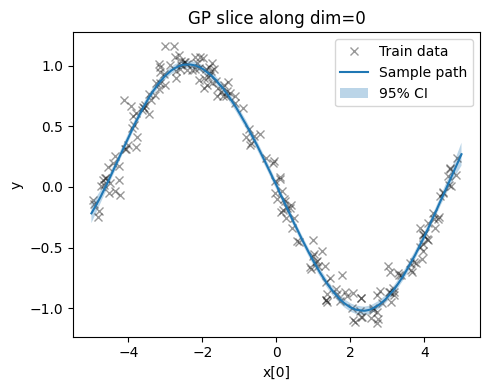

In [ ]:
D = X.shape[1]
dims = list(range(D))                # only sweep over dim 0
n_plots = len(dims)

fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 4), sharey=True)

# if there's only one subplot, matplotlib returns a single Axes, not a list
if n_plots == 1:
    axes = [axes]

for ax, dim in zip(axes, dims):
    # build the test grid: vary only coordinate `dim`, others fixed at 0
    x_grid = np.linspace(-5, 5, 200)
    X_test = np.zeros((len(x_grid), D))
    X_test[:, dim] = x_grid

    # predict
    pred_mean, pred_cov = predict_variational_sparse_gp(X, y, X_test, m_idx, learned_params)
    pred_var_marginal = np.diag(pred_cov)
    std = np.sqrt(pred_var_marginal)

    # draw one sample path from the posterior
    samples = np.random.multivariate_normal(pred_mean, pred_cov)
    # no need to reshape, it's already (200,)

    order = np.argsort(X_test[:, dim])
    x_plot    = X_test[order, dim]
    mean_plot = samples[order]
    std_plot  = std[order]

    # plot
    ax.plot(X[:, dim], y[:, 0], 'kx', alpha=0.4, label='Train data')
    ax.plot(x_plot, mean_plot,     label='Sample path')
    ax.fill_between(
        x_plot,
        mean_plot - 1.96*std_plot,
        mean_plot + 1.96*std_plot,
        alpha=0.3,
        label='95% CI'
    )
    ax.set_title(f'GP slice along dim={dim}')
    ax.set_xlabel(f'x[{dim}]')
    if dim == dims[0]:
        ax.set_ylabel('y')
    ax.legend()

plt.tight_layout()
plt.show()

## Variational Learning with CuPy

In [139]:
import cupy as cp

In [228]:
num_cuda = cp.cuda.runtime.getDeviceCount()
devices = []
for i in range(0, num_cuda):
    devices += [f'cuda:{i}']
devices

['cuda:0']

In [229]:
from scipy.optimize import minimize

def rbf_kernel(X1, X2, lengthscale, variance):
    """
    GPU RBF kernel via CuPy.
    X1: (N1, D) cp.array
    X2: (N2, D) cp.array
    """
    X1s = X1 / lengthscale
    X2s = X2 / lengthscale
    # ||x||^2 + ||y||^2 - 2 x·y
    sq_dists = (
        cp.sum(X1s**2, axis=1)[:, None]   # (N1,1)
      + cp.sum(X2s**2, axis=1)[None, :]   # (1,N2)
      - 2 * X1s.dot(X2s.T)               # (N1,N2)
    )
    return variance * cp.exp(-0.5 * sq_dists)


def variational_bound(params, X, y, m_idx):
    """
    CuPy version of your variational bound.
    Returns a Python float so SciPy can consume it.
    params = [lengthscale, variance, sigma2]
    X: (n, D) cp.array, y: (n,1) cp.array
    m_idx: list of ints
    """
    lengthscale, variance, sigma2 = params
    n = X.shape[0]

    if m_idx:
        Xm = X[m_idx]  # (m, D)
        # Kmm + jitter
        #print('A')
        Kmm = rbf_kernel(Xm, Xm, lengthscale, variance) + 1e-8 * cp.eye(len(m_idx))
        Kmn = rbf_kernel(Xm, X, lengthscale, variance)  # (m, n)

        #print('B')
        # Z = Kmm^{-1} Kmn
        Z = cp.linalg.solve(Kmm, Kmn)    # (m, n)
        Qnn = Kmn.T.dot(Z)               # (n, n)
        #print('C')
        trace_term = variance * n - cp.trace(Qnn)
        C = Qnn + sigma2 * cp.eye(n)
    else:
        trace_term = variance * n
        C = sigma2 * cp.eye(n)

    # Cholesky and α = C^{-1} y
    #print('D')
    L = cp.linalg.cholesky(C + 1e-6 * cp.eye(n))
    alpha = cp.linalg.solve(L.T, cp.linalg.solve(L, y[:, 0]))
    #print('E')
    # log det and likelihood
    log_det = 2.0 * cp.log(cp.diag(L)).sum()
    log_lik = -0.5 * (
        n * cp.log(2 * cp.pi) +
        log_det +
        (y[:, 0] * alpha).sum()
    )

    F = log_lik - 0.5 / sigma2 * trace_term
    return float(F.get())  # return a CPU float for SciPy


def greedy_variational_sparse_gp(X, y, M):
    """
    Greedy selection + SciPy hyper‐opt, but kernels & solves on GPU.
    X: cp.array (n,D), y: cp.array (n,1)
    """
    n = X.shape[0]
    params = [2.0, 0.1, 1.0]  # lengthscale, variance, sigma2
    m_idx = []

    for i in range(M):
        # print(i)
        best_j, best_F = None, -float('inf')
        # E-step: find the next inducing point
        for j in range(n):
            # if j%20==0:
            #     print(j)
            if j in m_idx:
                continue
            F_val = variational_bound(params, X, y, m_idx + [j])
            if F_val > best_F:
                best_F, best_j = F_val, j

        m_idx.append(best_j)

        # M-step: optimize lengthscale, variance, sigma2 on CPU via SciPy
        res = minimize(
            lambda h: -variational_bound(h, X, y, m_idx),
            params,
            bounds=[(1e-5, None), (1e-5, None), (1e-5, None)],
            method='L-BFGS-B'
        )
        params = res.x.tolist()
        print(f"Iter {i+1}/{M}: added idx {best_j}, F={best_F:.3f}, params={params}")

    return m_idx, params


# --- USAGE ---

# Suppose X_np, y_np are your original NumPy arrays:
#    X_np.shape == (n, D), y_np.shape == (n,1)

X_gpu = cp.asarray(X_train_reduced)
y_gpu = cp.asarray(y_train)

M = 80
m_idx, learned_params = greedy_variational_sparse_gp(X_gpu, y_gpu, M)

print("Final inducing indices:", m_idx)
print("Learned [lengthscale, variance, sigma2]:", learned_params)


Iter 1/80: added idx 2, F=-381.510, params=[280.1858641891273, 1e-05, 0.0002795300574996905]
Iter 2/80: added idx 22, F=1067.307, params=[280.1858641891273, 1e-05, 0.00027948892147272456]
Iter 3/80: added idx 301, F=1067.308, params=[280.1858641891273, 1e-05, 0.0002794889214661427]
Iter 4/80: added idx 169, F=1067.309, params=[280.1858641891273, 1e-05, 0.00027948892144410406]
Iter 5/80: added idx 232, F=1067.310, params=[280.1858641891273, 1e-05, 0.00027948892135145736]
Iter 6/80: added idx 25, F=1067.310, params=[280.1858641891273, 1e-05, 0.00027948892134681415]
Iter 7/80: added idx 325, F=1067.310, params=[280.1858641891273, 1e-05, 0.0002794889213288228]
Iter 8/80: added idx 217, F=1067.311, params=[280.1858641891428, 1e-05, 0.00027948873707958014]
Iter 9/80: added idx 45, F=1067.311, params=[280.1858641891428, 1e-05, 0.0002794881638970639]
Iter 10/80: added idx 356, F=1067.311, params=[280.18586418913543, 1e-05, 0.0002794880765825043]
Iter 11/80: added idx 13, F=1067.311, params=[28

In [ ]:
# m_dix [1419, 1524, 2218, 1447, 1526, 2099, 1525, 966, 1947, 1582, 878, 201, 598, 1801, 679, 911, 1041, 1491, 142, 645, 1579, 1562, 1241, 1743, 2146, 326, 963, 2378, 425, 1589, 385, 2142, 2010, 1714, 432, 1709, 1067, 207, 1806, 1255, 1044, 1126, 1749, 711, 1677, 2312, 1253, 379, 1527, 1035, 91, 1014, 1717, 436, 340, 1046, 1805, 986, 1713, 2103, 722, 14, 212, 2105, 288, 2300, 368, 467, 2075, 200, 1803, 424, 1110, 1071, 1648, 181, 526, 292, 2357, 957]
# learned_params= [22.679975010085133, 1e-05, 0.00025155456629189795]

In [230]:
X_test_reduced.shape

(100, 10)

In [231]:
#Redefine RBF kernel
def rbf_kernel(X1, X2, lengthscale, variance):
    X1s = X1 / lengthscale # (N1, D)
    X2s = X2 / lengthscale # (N2, D)
    sq_dists = (
        np.sum(X1s**2, axis=1)[:,None] #(N1,1)
      + np.sum(X2s**2, axis=1)[None,:] #(1,N2) # with broadcasting it makes (N1,N2)
      - 2*X1s.dot(X2s.T) # (N1,N2)
    )
    return variance * np.exp(-0.5 * sq_dists)

def predict_variational_sparse_gp(X, y, X_test, m_idx, params):
    lengthscale, variance, sigma2 = params
    Xm = X[m_idx]
    Kmm = rbf_kernel(Xm, Xm, lengthscale, variance) + 1e-8 * np.eye(len(Xm))
    Kmn = rbf_kernel(Xm, X, lengthscale, variance)
    # Optimal variational distribution phi* parameters
    Sigma = np.linalg.inv(Kmm + (1/sigma2) * (Kmn.dot(Kmn.T))) #(m, m)
    mu_phi = (1/sigma2)*Kmm.dot(Sigma.dot(Kmn.dot(y[:, 0]))) #(m, 1)
    # Predictive mean
    K_test_m = rbf_kernel(X_test, Xm, lengthscale, variance) #(N_test, m)
    pred_mean = K_test_m.dot(np.linalg.solve(Kmm, mu_phi)) #(N_test, 1)
    # Predictive variance
    Kxx = rbf_kernel(X_test, X_test, lengthscale, variance) + 1e-6 * np.eye(len(X_test))
    Z = np.linalg.solve(Kmm, K_test_m.T) #(m, N_test)
    var1 = Kxx - K_test_m.dot(Z)
    var2 = K_test_m.dot(Sigma.dot(K_test_m.T))
    pred_var = var1 + var2
    return pred_mean, pred_var #(N_test,1) (N_test,N_test)

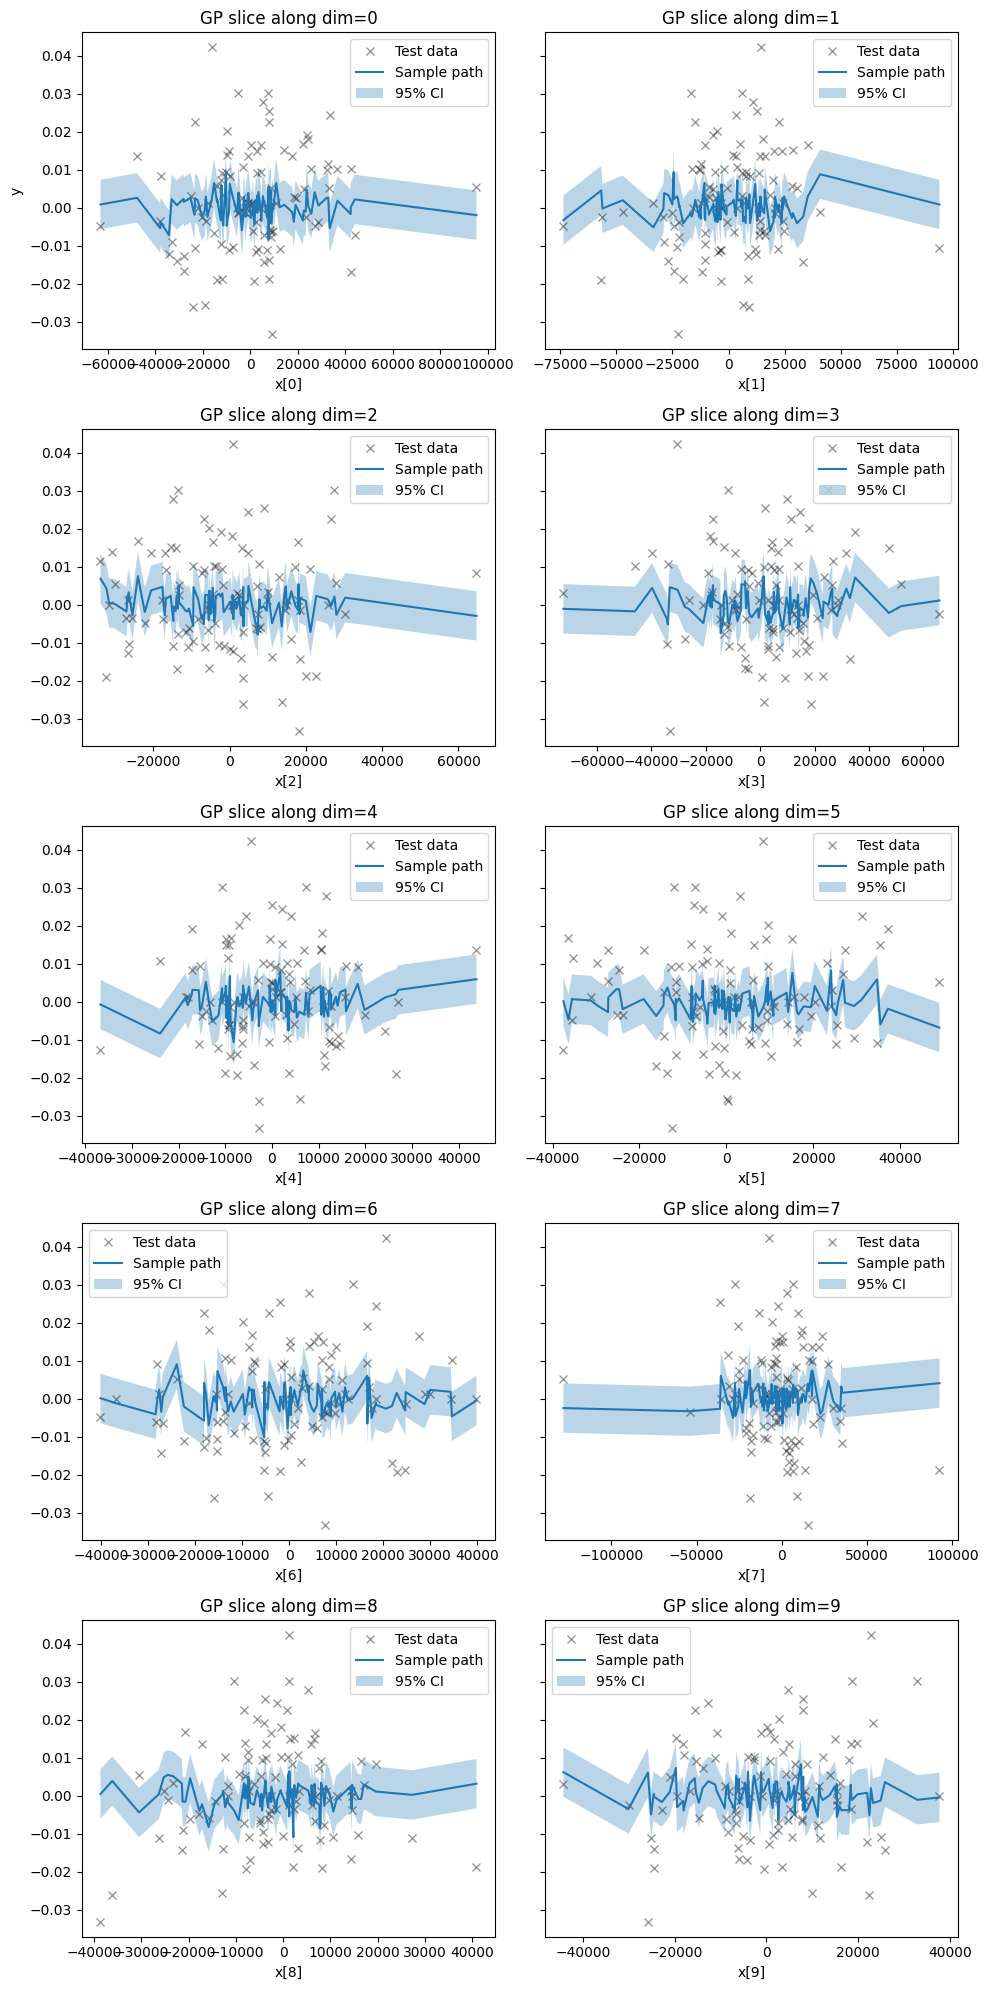

In [232]:
D       = X_test_reduced.shape[1]
dims    = list(range(D))      # which features to slice over
n_plots = len(dims)

# choose a layout, e.g. 6 rows, ceil(n_plots/6) columns
nrows   = 5
ncols   = int(np.ceil(n_plots / nrows))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 20), sharey=True)

# flatten and trim to exactly n_plots axes
axes = axes.flatten()[:n_plots]

for ax, dim in zip(axes, dims):
    # predict
    pred_mean, pred_cov = predict_variational_sparse_gp(
        X_train_reduced, y_train, X_test_reduced, m_idx, learned_params
    )
    pred_var_marginal = np.diag(pred_cov)
    std = np.sqrt(pred_var_marginal)

    # draw one sample path from the posterior
    samples = np.random.multivariate_normal(pred_mean.flatten(), pred_cov)

    # sort for plotting
    order     = np.argsort(X_test_reduced[:, dim])
    x_plot    = X_test_reduced[order, dim]
    mean_plot = samples[order]
    std_plot  = std[order]

    # now ax is a single Axes object
    ax.plot(X_test_reduced[:, dim], y_test[:, 0], 'kx', alpha=0.4, label='Test data')
    ax.plot(x_plot, mean_plot, label='Sample path')
    ax.fill_between(
        x_plot,
        mean_plot - 1.96*std_plot,
        mean_plot + 1.96*std_plot,
        alpha=0.3,
        label='95% CI'
    )

    ax.set_title(f'GP slice along dim={dim}')
    ax.set_xlabel(f'x[{dim}]')
    if dim == dims[0]:
        ax.set_ylabel('y')
    ax.legend()

plt.tight_layout()
plt.show()


RMSE = 0.0140
 MAE = 0.0108
 R²  = -0.0903


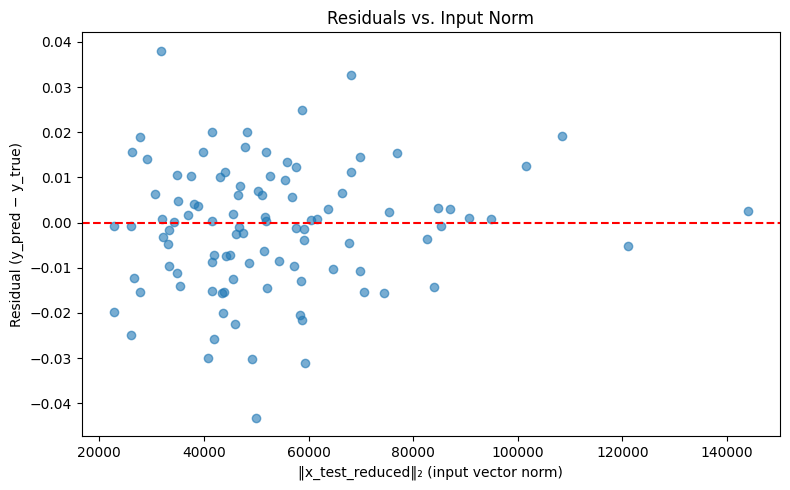

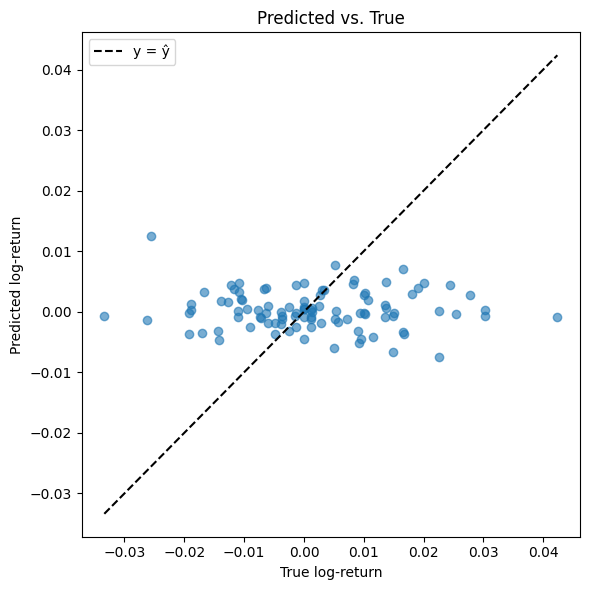

In [233]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Get your predictions
#    (assumes predict_variational_sparse_gp returns pred_mean as (n_test,1))
pred_mean, pred_cov = predict_variational_sparse_gp(
    X_train_reduced, y_train, X_test_reduced, m_idx, learned_params
)
y_true = y_test[:, 0]
y_pred = np.random.multivariate_normal(pred_mean.flatten(), pred_cov)

# y_pred = pred_mean.flatten()

# 2) Compute input‐vector norms
x_norm = np.linalg.norm(X_test_reduced, axis=1)  # shape (n_test,)

# 3) Compute errors & summary metrics
errors  = y_pred - y_true
rmse     = np.sqrt(np.mean(errors**2))
mae      = np.mean(np.abs(errors))
ss_res   = np.sum(errors**2)
ss_tot   = np.sum((y_true - np.mean(y_true))**2)
r2       = 1 - ss_res/ss_tot

print(f"RMSE = {rmse:.4f}")
print(f" MAE = {mae:.4f}")
print(f" R²  = {r2:.4f}")


# 4) Residuals vs. Input‐Norm
plt.figure(figsize=(8,5))
plt.scatter(x_norm, errors, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("‖x_test_reduced‖₂ (input vector norm)")
plt.ylabel("Residual (y_pred − y_true)")
plt.title("Residuals vs. Input Norm")
plt.tight_layout()

# 5) True vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', label="y = ŷ")
plt.xlabel("True log-return")
plt.ylabel("Predicted log-return")
plt.title("Predicted vs. True")
plt.legend()
plt.tight_layout()

plt.show()


RMSE = 0.0167
 MAE = 0.0126
 R²  = 0.0013


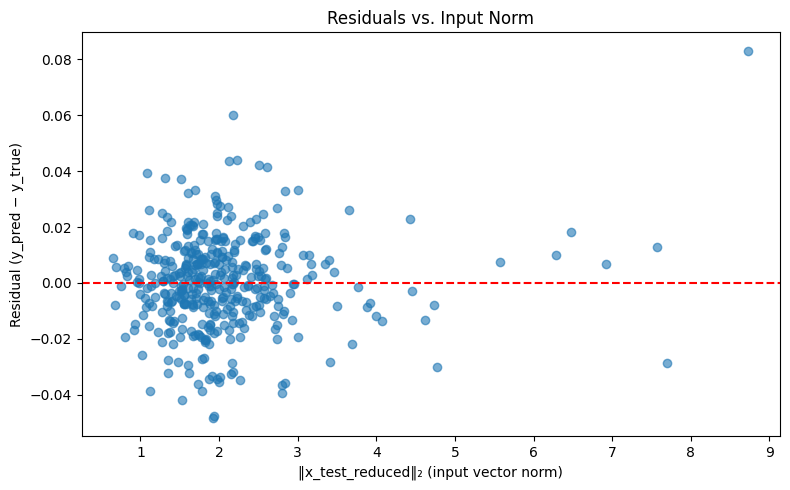

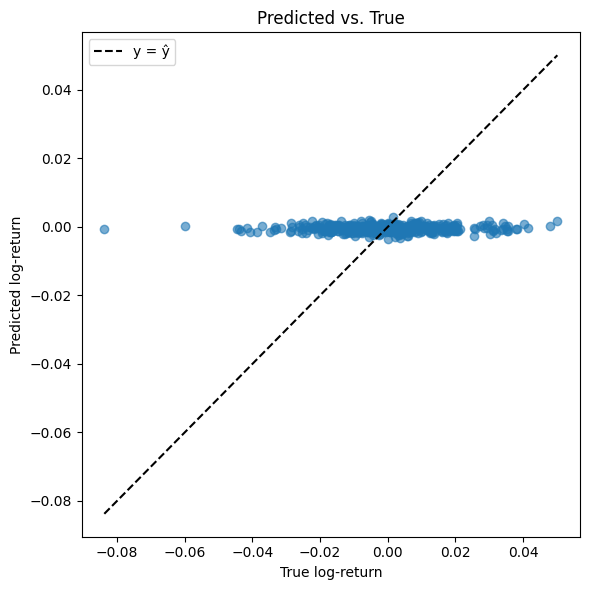

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Get your predictions
#    (assumes predict_variational_sparse_gp returns pred_mean as (n_test,1))
pred_mean, pred_cov = predict_variational_sparse_gp(
    X_train_reduced, y_train, X_train_reduced, m_idx, learned_params
)
y_true = y_train[:, 0]
y_pred = np.random.multivariate_normal(pred_mean.flatten(), pred_cov)

# y_pred = pred_mean.flatten()

# 2) Compute input‐vector norms
x_norm = np.linalg.norm(X_train_reduced, axis=1)  # shape (n_test,)

# 3) Compute errors & summary metrics
errors  = y_pred - y_true
rmse     = np.sqrt(np.mean(errors**2))
mae      = np.mean(np.abs(errors))
ss_res   = np.sum(errors**2)
ss_tot   = np.sum((y_true - np.mean(y_true))**2)
r2       = 1 - ss_res/ss_tot

print(f"RMSE = {rmse:.4f}")
print(f" MAE = {mae:.4f}")
print(f" R²  = {r2:.4f}")


# 4) Residuals vs. Input‐Norm
plt.figure(figsize=(8,5))
plt.scatter(x_norm, errors, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("‖x_test_reduced‖₂ (input vector norm)")
plt.ylabel("Residual (y_pred − y_true)")
plt.title("Residuals vs. Input Norm")
plt.tight_layout()

# 5) True vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', label="y = ŷ")
plt.xlabel("True log-return")
plt.ylabel("Predicted log-return")
plt.title("Predicted vs. True")
plt.legend()
plt.tight_layout()

plt.show()
